# Predicting El Niño–Southern Oscillation through correlation and time series analysis - Part 1&2

This example uses correlation analysis and time series analysis to predict El Niño–Southern Oscillation (ENSO) based on climate variables and indices. ENSO is an irregular periodical variation in winds and sea surface temperatures over the tropical eastern Pacific Ocean.

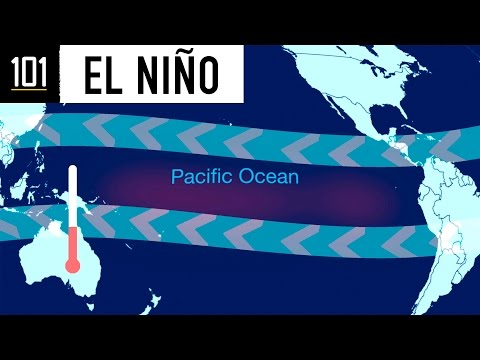

In [111]:
from IPython.display import YouTubeVideo
YouTubeVideo('d6s0T0m3F8s')

ENSO can have tremendous potential impact such as droughts, floods, and tropical storms. You can look at a few story maps below to get a better understanding of the process.

In [112]:
from arcgis.gis import GIS
agol = GIS()
story_maps = agol.content.search('What El Niño Means for Southern California')[0]
story_maps

<Item title:"What El Niño Means for Southern California" type:Web Mapping Application owner:NWS.LOX_noaa>

Accurate characterization of ENSO is critical for understanding the trends. In climate science, ENSO is characterized through [Southern Oscillation Index](https://www.ncdc.noaa.gov/teleconnections/enso/indicators/soi/) (SOI), a standardized index based on the observed sea level pressure differences between Tahiti and Darwin, Australia. If SOI exhibits warm (greater than 0.5) or cool phase conditions for at least five consecutive values, it officially becomes an El Niño or La Niña event. Therefore, predicting SOI is the first step of ENSO forecasting. This notebooks consists of 3 sections: (1) Data exploration (2) correlation analysis; (3) Time series analysis

## Data used
The following four variables were used in this examplea as ENSO is beleived to be related to sea surface temperature, sea level pressure, precipitation, etc. 
1. Oceanic Nino Index (ONI), a climate index used for sea surface temperature (SST).
2. Eastern Tropical Pacific SST (Nino 3), another climate index used for SST focusing on a slightly different region.
3. Pacific North American Index (PNA). PNA is a closely related phenomena to ENSO.
4. Precipitation monthly mean. Historical global precipitation monthly mean in raster format.

## Part 1. Data exploration
The first three variables along with SOI has been put into a .CSV file. To give you an overview, let's read it and look at the first few lines.

In [1]:
%matplotlib inline

import numpy as np
import pandas as pd
from pandas import read_csv
from pandas import datetime
from matplotlib import pyplot

def parser(x):
    if x.endswith('11') or x.endswith('12')or x.endswith('10'):
        return datetime.strptime(x, '%Y%m')
    else:
       return datetime.strptime(x, '%Y0%m') 
df = read_csv('data/enso_original.csv', header=0, parse_dates=[0], index_col=0, date_parser=parser)
start = 336 
df = df.iloc[start:]
df = (df - df.mean()) / df.std()
print(df.head())

                 soi       oni     nino3       pna
date                                              
1979-01-01 -0.441750 -0.059963 -0.150376 -1.537109
1979-02-01  0.997371  0.056451 -0.271512 -2.725606
1979-03-01  0.072222  0.172865 -0.139364  0.080846
1979-04-01 -0.133367  0.289280  0.213033 -0.148864
1979-05-01  0.483399  0.172865  0.036835  1.269344


Let us examine how SOI changes over time.

Text(0.5,0,'Time')

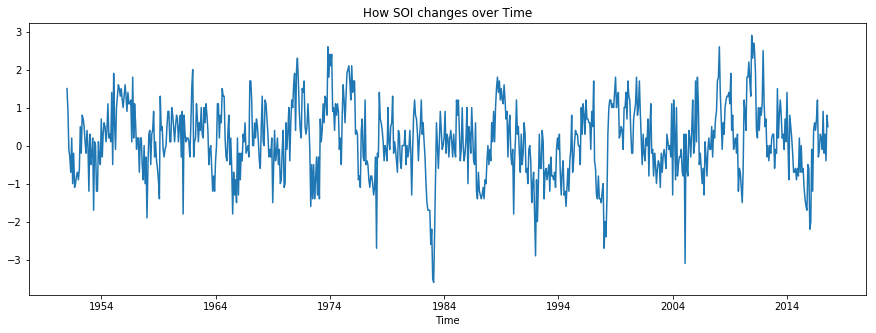

In [114]:
pyplot.figure(figsize=(15,5))
pyplot.plot(df.soi)
pyplot.title('How SOI changes over Time')
pyplot.xlabel('Time')

Let us put all four variables together and see how they are distributed or if there is any visual relationship.

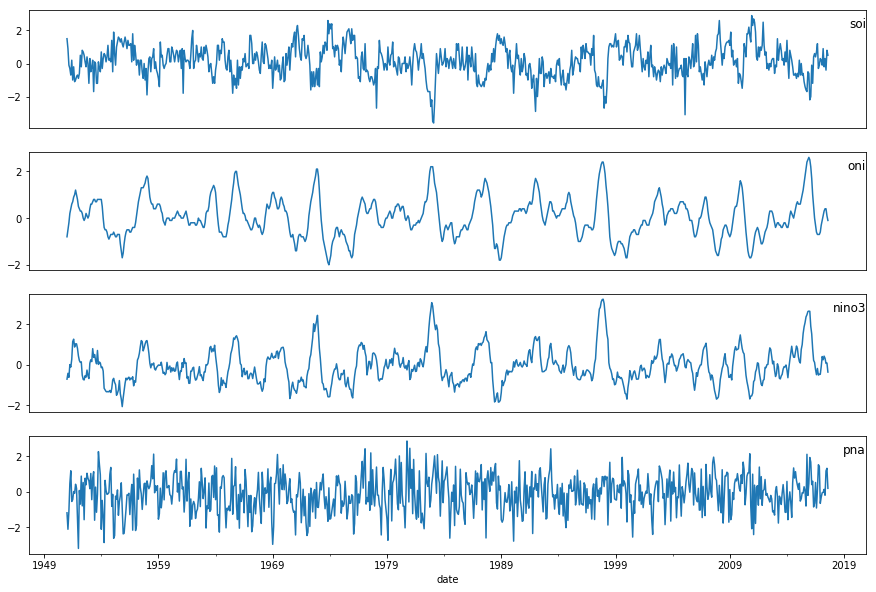

In [115]:
i = 1
fig = pyplot.figure(figsize=(15,10))
for col in df.columns.tolist():
    fig.add_subplot(len(df.columns.tolist()), 1, i)
    df[col].plot()
    pyplot.title(col, y=0.8, loc='right')
    if i != len(df.columns.tolist()):
        pyplot.tick_params(
            axis='x',          # changes apply to the x-axis
            which='both',      # both major and minor ticks are affected
            bottom=False,      # ticks along the bottom edge are off
            top=False,         # ticks along the top edge are off
            labelbottom=False) # labels along the bottom edge are off
        pyplot.xlabel('')
    i += 1
pyplot.show()

As we can see, there is some relationship between the input variables (i.e., oni, nino3, pna) and output variable, soi. For example, oni and soi look highly negatively correlated. We will cover how to model SOI using these variables in the time series analysis, but first let's look at how to bring in the last variable - precipitation.

## Part 2. Correlation analysis
Global precipitation monthly mean is avaialble in raster format on ArcGIS online. In this part, we will cover how to indentify the most correlated (on time dimension) grid cell through lagged correlation analysis. There are two rationals behind this. 
1. In climate science, a phenomenon that is happening now could be a result of what has happend in the past. In other words, SOI of this month could be most correlated with the ONI of last month or the month before depending on the actual physical process.
2. ENOS is a type of teleconnection which refers to climate anomalies being related to each other at large distances.

First, let us search and acess the precipitation data from ArcGIS Online.

In [116]:
data = agol.content.search('Global Monthly Precipitation 1979-2017')[0]
data

<Item title:"Global Monthly Precipitation 1979-2017" type:Image owner:yjiang_geosaurus>

In [117]:
data_item = agol.content.get(data.id)
# data_item.download(save_path = r'data/')

Once the data is download to local, we can read it and visualize it through skimage and matplotlib to get a sense of what the data looks like. Because the spatial resolution is 2.5 by 2.5 degrees, there are 72 rows and 144 columns. The third dimension is the time dimension as the data contains monthly mean from 1970.1 to 2017.10, which is 466 months in total.

(72, 144, 466)


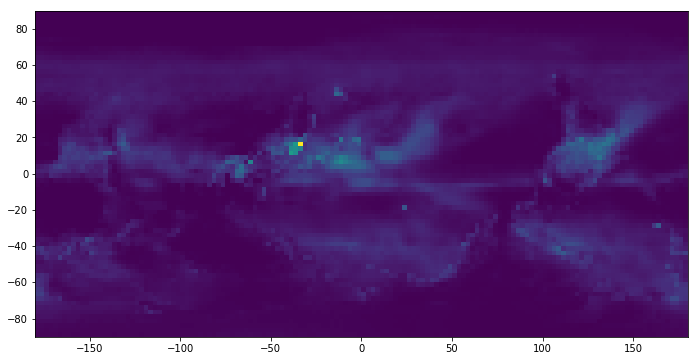

In [118]:
from skimage import io
import math
from scipy.stats.stats import pearsonr
from numpy import unravel_index

precip_full = io.imread('data/precipitation.tif')
precip_full = np.flip(precip_full, 0)

# print the dimension of the precip_full, (lat, lon, time)
print(precip_full.shape)
# let's print out the first month/band of this data
pyplot.figure(figsize=(15,6))
pyplot.imshow(precip_full[:,:,0], extent=[-180, +180, -90, 90])

Before calculating the correlation, let's transform the precipitation monthly mean to precipitation anomaly, which a usually provides better signal than absolute precipitation. For short, anomaly means how much precipitation departs from what is normal for that time of year at a specific location. Let's say, we would like to know the anomaly of a specific grid in October this year. We need to compute the historial mean of October precipitation and then caculate its difference with value of this October.

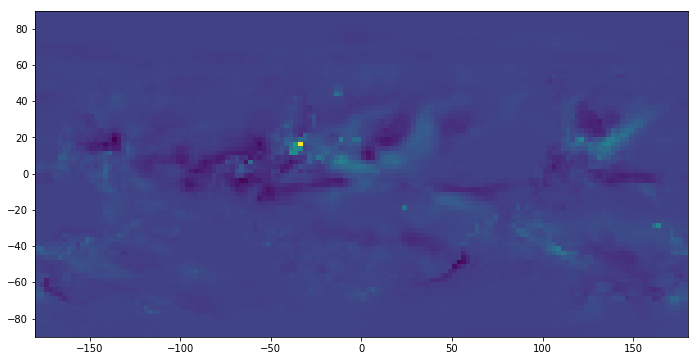

In [119]:
# calculate the historical mean for each month
a = np.zeros(shape = (precip_full.shape[0], precip_full.shape[1], math.ceil(precip_full.shape[2]/12)*12))
a[:,:,0:precip_full.shape[2]] = precip_full
a = a.reshape(a.shape[0], a.shape[1], int(a.shape[2]/12), 12)
monthly_sum = np.sum(a, axis=2)

montly_mean_1_10 = monthly_sum[:,:,0:10]/a.shape[2]
montly_mean_11_12 = monthly_sum[:,:,-2:]/(a.shape[2] - 1)
monthly_mean = np.append(montly_mean_1_10, montly_mean_11_12, axis=2)

# calculate the difference
for i in range(a.shape[3]):
    a[:,:,i,:] -=monthly_mean

# reshape the data back to its orginial dimension
a = a.reshape(a.shape[0], a.shape[1], a.shape[2]*a.shape[3])

# visualize the first month anomaly
pyplot.figure(figsize=(15,6))
pyplot.imshow(a[:,:,0], extent=[-180, +180, -90, 90])

Now we have the anomaly. Let us calculate Pearson correlation coefficient between SOI and precipitation anomaly across all the grids based on a range of time lag from 0 to 5. The goal is the find the grid that has the greatest absolute Pearson correlation.

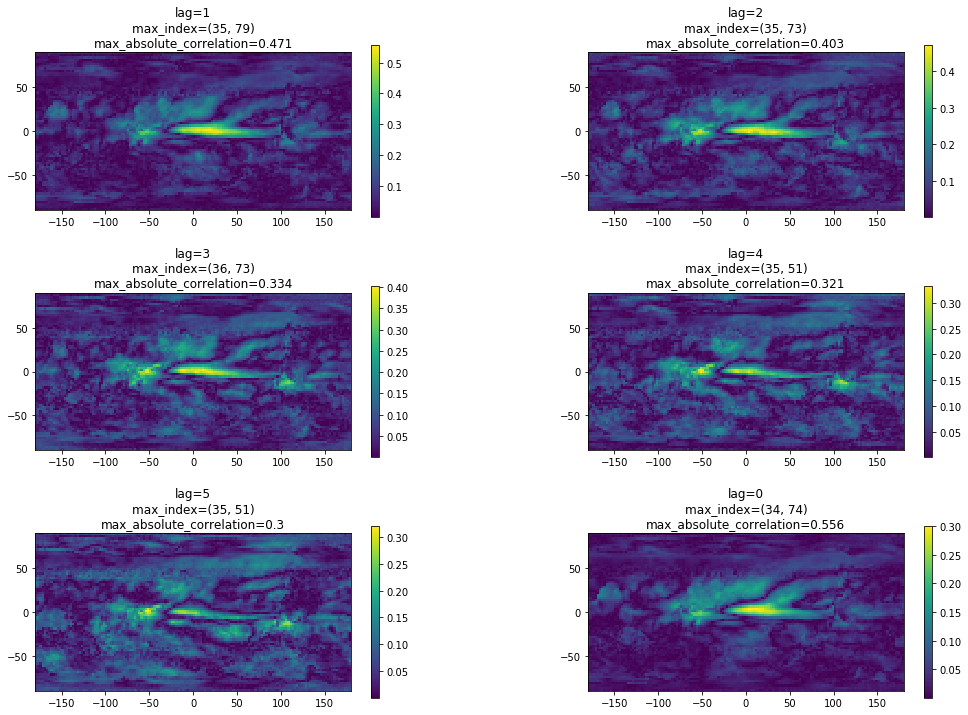

In [120]:
lag = 5
fig, axs = pyplot.subplots(nrows=3, ncols=2, figsize=(14, 12))
fig.subplots_adjust(left=0.03, right=0.97, hspace=0.4, wspace=0.4)

for t in range(lag+1):
    # if t=0, soi starts from 1982 
    soi = df.values[336+t:,0]   
    soi = soi.reshape(soi.shape[0], 1)

    precip = a[:,:,0:-4-t]
    
    r2 = []
    for i in range(precip.shape[0]):
        for j in range(precip.shape[1]):
            r2_index = pearsonr(soi, precip[i,j,:].reshape(precip.shape[2], 1))[0]
            r2.append(r2_index)

    r2_map = np.array(r2).reshape(precip.shape[0], precip.shape[1])
    max_index = unravel_index(r2_map.argmax(), r2_map.shape)

    im = axs.flat[t-1].imshow(np.abs(r2_map), extent=[-180, +180, -90, 90])
    fig.colorbar(im, ax = axs[t//2, t%2])
    
    # we only care only absolute correlation in this case
    r2_map = np.abs(r2_map)
    max_index = unravel_index(r2_map.argmax(), r2_map.shape)
    axs.flat[t-1].set_title('lag=' + str(t) + '\n' + 'max_index=' + str(max_index) + '\n' + 'max_absolute_correlation=' + str(float("%.3f" % r2_map[max_index])))


As can be seen, the largest correlation results from lag=0 at (row, column) = (34, 74). We will then take the precipitation anomaly of this grid and combine it with the other variables to predict SOI in another notebook.